# SEL 2017/18 - Practical Work 3 - CBR prototype for planning

1. Introduction
    1. Basic principles of the CBR engine project. The general ideas of the CBR engine implemented, from a technical point of view. That means explaining what are the general implementation guidelines of your project (which kind of Case Library structure, which kind of case structure, etc., without giving more details).
    2. Chosen application domain
    
2. Requirement Analysis of the CBR engine Project. The requirements include both the user requirements (main functionalities of the system that user needs, i.e., what the system must do?) and the technical requirements of the system (maximum time response of the system, maximum memory size of the system, etc.).

3. Functional Architecture of the CBR engine Project, describing the input, the output, the different components of the system and their interactions.

4. Proposed CBR engine Project solution design:
    1. Case Structure and Case Library structure designed
    2. Methods implementing each CBR cycle step (retrieval, adaptation, evaluation and learning)
    
5. Testing and evaluation.

6. Discussion of results.

## 1. Introduction
 
In this document we present the work done for the third delivery of the subject Supervised and Experimental Learning (SEL), which is about designing a CBR for planning. A CBR based on the use of several Heuristics has been developed and used in three different well known planning domains. A discussion about the results is also provided at the end of the document.


### 1.1. Basic Principles of the CBR engine project

Our aim was to implement a CBR engine which combined several heuristics in order to give a closer estimation of the optimal length of the plan to solve one of our domain's problems. In our project, we have considered that the cost of performing an action is uniform, so that we will not make any difference between number of states and cost of a plan. 

The general idea of our work is to use the heuristic calculated by the CBR as the perfect heuristic of any search algorithm used in pathfinding and graph traversal (IDA*, A*, etc.). We use A*, which guarantees to find the optimal plan if an only if the found heuristic is admissible, that is, it is smaller or equal to the perfect heuristic. However, in our case, we have relaxed the condition of  finding the optimal plan, in order to save computational cost and find a valid path quicker. Specifically, we do not look at the absolute value of the heuristic, but at the order that the heuristic produces in the states which are part of the plan.

The Case Library Structure we have used is *k-d tree*, the reason is that we work with numerical values which can be organised following such a structure. For us, each case is a vector of numbers, specifically, a vector of heuristics. 


### 1.2. Chosen application domain

For this practical work we have chosen three different domains: The Tower of Hanoi, Blocks World and Elevators. All of them are typical domains used in Planning. We present the three domains and show examples of them using blind search methods (BFS and IDS). We also use those methods as target in order to test our CBR system. 

Nevertheless, our project is quite ambitious because we have implemented it for general purpose. It can be apply to any kind of problem which can be written using the sintax used in STRIPS. 

#### 1.2.1. The Tower of Hanoi
The Tower of Hanoi is a mathematical game or puzzle. It consists of three rods and a number of disks of different sizes, which can slide onto any rod. The puzzle starts with the disks in a neat stack in ascending order of size on one rod, the smallest at the top, thus making a conical shape.

The objective of the puzzle is to move the entire stack to another rod, obeying the following simple rules:

1. Only one disk can be moved at a time.
2. Each move consists of taking the upper disk from one of the stacks and placing it on top of another stack.
3. No disk may be placed on top of a smaller disk.

We have defined the domain in Python and it contains a single operator: `move(?what-disk, ?from-object, ?to-object)`, which moves disk `?what` from object `?from` (either a peg or another disk) to object `?to` (also, either a peg or a disk). Our planning framework can take care of static preconditions. That is, it does not instantiate the move operator for moving a disk onto a smaller disk) so it is not necessary to encode static predicates in the state (the `smaller(?disk1,?disk2)` predicates that are typically seen in PDDL Hanoi domains).

We have also implemented a problem generator. The generator can create problems for any number of disks and pegs. It also allows random initial and ending configurations. Our first example will be fairly simple and will have 3 pegs, all the disks in the first peg in the initial state and all the disks in the third peg in the goal configuration. Although the goal in this case details the position of every disk, notice that this does not necessarily has to be the case always. The goal does not need to be a complete description of the end configuration. It is perfectly reasonable, and our framework allows it, to consider partial states (e.g. we want the biggest disk in the third peg, and we do not care about the rest).

In [1]:
import planning

from IPython.display import display

Domain: Hanoi
Types: {'peg': 'object', 'disk': 'object'}
Operators:
  - move(?what-disk,?from-object,?to-object):
    Pre: clear(?what), clear(?to), on(?what,?from), smaller(?what,?to)
    Add: clear(?from), on(?what,?to)
    Delete: clear(?to), on(?what,?from)
Init:


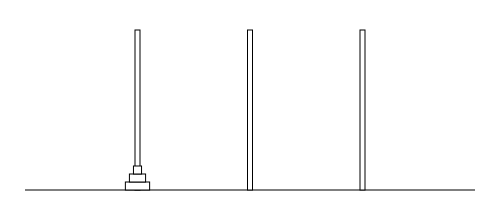

Goal:


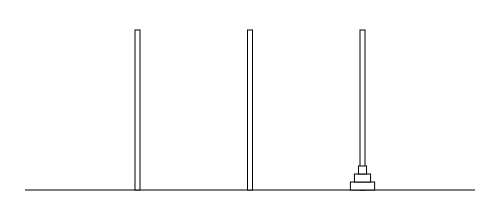

Applicable actions in 1st state:
move(disk01,disk02,peg2)
move(disk01,disk02,peg3)


In [2]:
domain_name = "Hanoi"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 3, random=False)
print(domain)
# print(problem)
print("Init:")
display(problem.init())
print("Goal:")
display(problem.goal())
print("Applicable actions in 1st state:")
l = list(filter(problem.init().can_apply, problem.operators()))
print("\n".join(map(str, l)))
# print(planning.pddl_utility.pddl_actions(l))
# print(planning.pddl_utility.pddl_domain(domain, problem.operators()))
# print(planning.pddl_utility.pddl_problem(problem))

with open("domain"+domain_name+".pddl", "w") as d, open("problem"+domain_name+".pddl","w") as p:
    d.write(planning.pddl_utility.pddl_domain(domain, problem.operators()))
    p.write(planning.pddl_utility.pddl_problem(problem))


We can solve this problem so that we get the following result.

[0.003s] Plan found with 7 action(s)
#Generated nodes: 24
Plan:
  move(disk01,disk02,peg3)
  move(disk02,disk03,peg2)
  move(disk01,peg3,disk02)
  move(disk03,peg1,peg3)
  move(disk01,disk02,peg1)
  move(disk02,peg2,disk03)
  move(disk01,peg1,disk02)
step 0


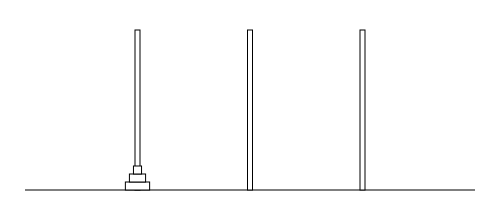

step 1


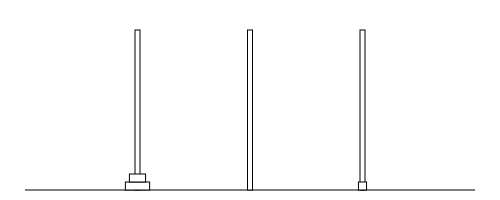

step 2


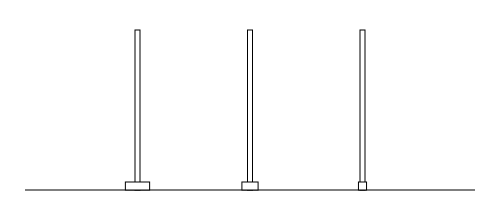

step 3


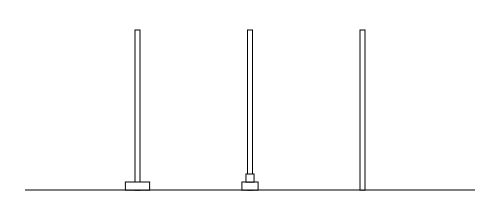

step 4


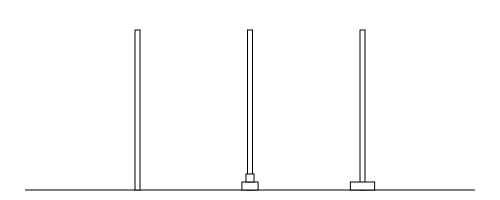

step 5


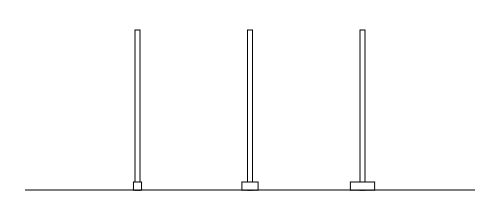

step 6


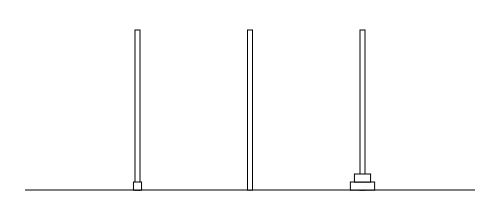

step 7


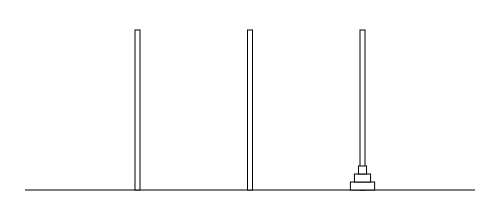

In [3]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if True: #len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

#### 1.2.2. Blocks World
The blocks world is one of the most famous planning domains in artificial intelligence. Imagine a set of wooden blocks of various shapes and colors sitting on a table. The goal is to build one or more vertical stacks of blocks. The catch is that only one block may be moved at a time: it may either be placed on the table or placed atop another block. Because of this, any blocks that are, at a given time, under another block cannot be moved. Moreover, some kinds of blocks cannot have other blocks stacked on top of them.

The simplicity of this toy world lends itself readily to symbolic or classical A.I. approaches, in which the world is modeled as a set of abstract symbols which may be reasoned about.

One relevant difference between our implementation of the domain with respect to the original one, is that our table is not infinite, we actually let users choose the number of slots (positions) that the table will have. 

We have defined the domain in Python and it contains a two operators: `pick(?what-block, ?from-object, ?to-object)`, which picks block `?what` from object `?from` (either a slot of the table or another block) and `put(?what-block, ?to-object)`, which puts block to object `?to` (also, either one position of the table or a block). Our planning framework can take care of static preconditions (no instantiations of operators for one block with itself).

We have also implemented a problem generator. The generator can create problems for any number of blocks and slots on the table. Our first example will be fairly simple and will have 3 blocks, and 3 slots.

In [4]:
import planning

from IPython.display import display

Domain: Blocks
Types: {'block': 'object', 'slot': 'object'}
Operators:
  - pick(?what-block,?from-object):
    Pre: clear(?what), on(?what,?from), handempty()
    Add: clear(?from), holding(?what)
    Delete: clear(?what), on(?what,?from), handempty()
  - put(?what-block,?to-object):
    Pre: holding(?what), clear(?to)
    Add: clear(?what), on(?what,?to), handempty()
    Delete: holding(?what), clear(?to)
Init:


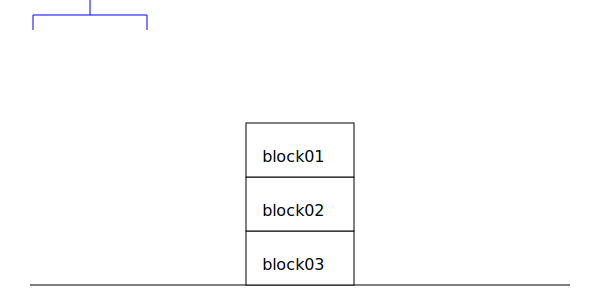

Goal:


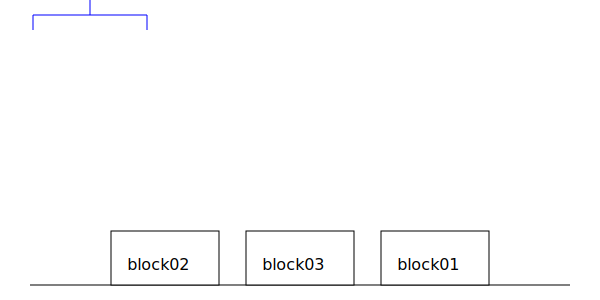

Applicable actions in 1st state:
pick(block01,block02)


In [5]:
domain_name = "Blocks"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 3)
print(domain)
# print(problem)
print("Init:")
display(problem.init())
print("Goal:")
display(problem.goal())
print("Applicable actions in 1st state:")
l = list(filter(problem.init().can_apply, problem.operators()))
print("\n".join(map(str, l)))

with open("domain"+domain_name+".pddl", "w") as d, open("problem"+domain_name+".pddl","w") as p:
    d.write(planning.pddl_utility.pddl_domain(domain, problem.operators()))
    p.write(planning.pddl_utility.pddl_problem(problem))


We can solve this problem so that we get the following result.

[0.001s] Plan found with 4 action(s)
#Generated nodes: 8
Plan:
  pick(block01,block02)
  put(block01,slot3)
  pick(block02,block03)
  put(block02,slot1)
step 0


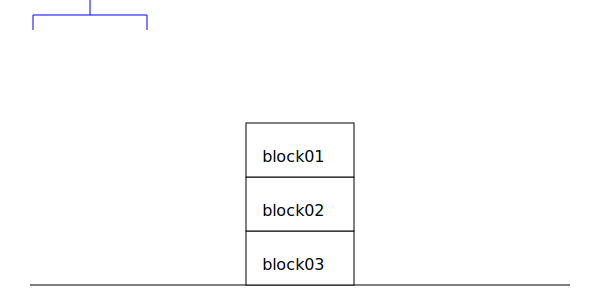

step 1


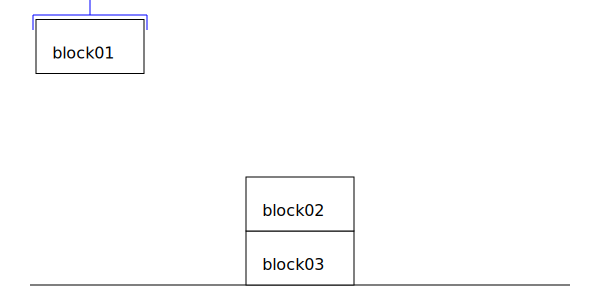

step 2


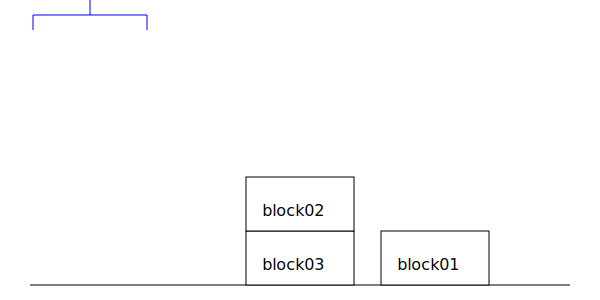

step 3


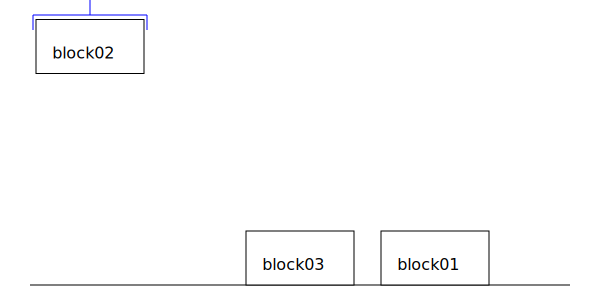

step 4


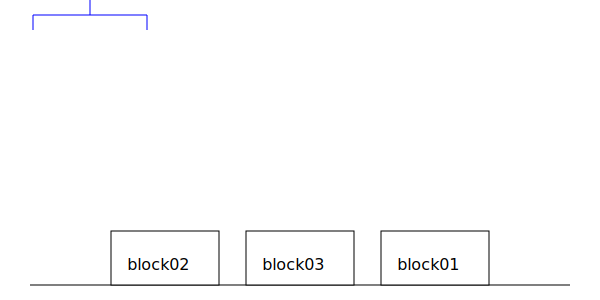

In [6]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if True: #len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

#### 1.2.3. Elevators Domain
Let's consider we have a building with several foors and people who want to go from one floor to another one. A lift, starting from one of the floors, has to satisfy all people petitions. The resctrictions are the following:

1. The lift can just move one floor each step
2. Just one person can get into/outo the lift each step


We have defined the domain in Python and it contains a four operators: 

1. `board(?f-floor, ?p-passenger)`, which boards the passenger `?p` which is in the floor `?f`.
2. `depart(?f-floor, ?p-passenger)`, which departs the passenger `?p` in the floor `?f`. The passenger passes to be served.
3. `drive_up(?f1-floor, ?f2-floor)`, the lift goes up from floor `?f1` to floor `?f2`.
4. `drive_down(?f1-floor, ?f2-floor)`, the lift goes down from floor `?f1` to floor `?f2`.

Our planning framework can take care of static preconditions (no instantiations of operators for the same instance).

We have also implemented a problem generator. The generator can create problems for any number of people and floors. Our first example will be fairly simple and will have 4 people and 4 floors. Again, we use BFS and IDS.

Domain: Elevator
Types: {'passenger': 'object', 'floor': 'object'}
Operators:
  - board(?f-floor,?p-passenger):
    Pre: lift-at(?f), origin(?p,?f)
    Add: boarded(?p)
    Delete: 
  - depart(?f-floor,?p-passenger):
    Pre: lift-at(?f), destin(?p,?f), boarded(?p)
    Add: served(?p)
    Delete: boarded(?p)
  - drive_down(?f1-floor,?f2-floor):
    Pre: lift-at(?f1), above(?f2,?f1)
    Add: lift-at(?f2)
    Delete: lift-at(?f1)
  - drive_up(?f1-floor,?f2-floor):
    Pre: lift-at(?f1), above(?f1,?f2)
    Add: lift-at(?f2)
    Delete: lift-at(?f1)
Problem: elevator-00
Domain: Elevator
Initial state:
  above(floor1,floor2)
  above(floor2,floor3)
  above(floor3,floor4)
  destin(passenger01,floor1)
  destin(passenger02,floor3)
  destin(passenger03,floor1)
  lift-at(floor4)
  origin(passenger01,floor2)
  origin(passenger02,floor1)
  origin(passenger03,floor2)
Goal:
  above(floor1,floor2)
  above(floor2,floor3)
  above(floor3,floor4)
  destin(passenger01,floor1)
  destin(passenger02,floor3)
 

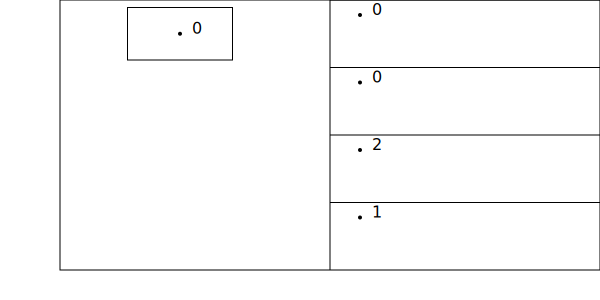

Goal:
Applicable actions in 1st state:
drive_down(floor4,floor3)


In [7]:
domain_name = "Elevator"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 4)
print(domain)
print(problem)
print("Init:")
display(problem.init())
print("Goal:")
#display(problem.goal())
print("Applicable actions in 1st state:")
print("\n".join(map(str, filter(problem.init().can_apply, problem.operators()))))

with open("domain"+domain_name+".pddl", "w") as d, open("problem"+domain_name+".pddl","w") as p:
    d.write(planning.pddl_utility.pddl_domain(domain, problem.operators()))
    p.write(planning.pddl_utility.pddl_problem(problem))

We can solve this problem so that we get the following result.

[0.016s] Plan found with 11 action(s)
#Generated nodes: 141
Plan:
  drive_down(floor4,floor3)
  drive_down(floor3,floor2)
  board(floor2,passenger01)
  board(floor2,passenger03)
  drive_down(floor2,floor1)
  board(floor1,passenger02)
  depart(floor1,passenger01)
  depart(floor1,passenger03)
  drive_up(floor1,floor2)
  drive_up(floor2,floor3)
  depart(floor3,passenger02)
step 0
{'floor2': 2, 'floor3': 0, 'floor1': 1, 'floor4': 0}


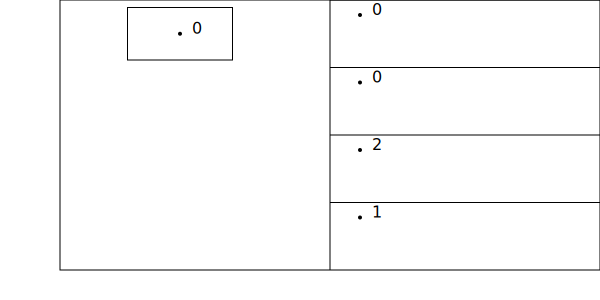

step 1
{'floor2': 2, 'floor3': 0, 'floor1': 1, 'floor4': 0}


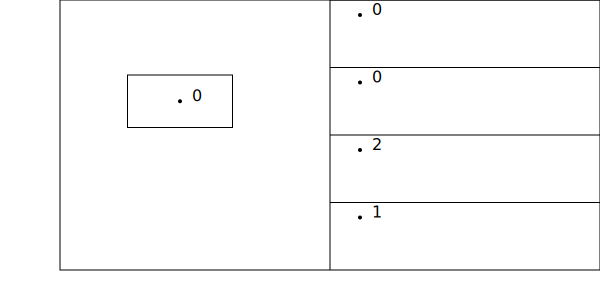

step 2
{'floor2': 2, 'floor3': 0, 'floor1': 1, 'floor4': 0}


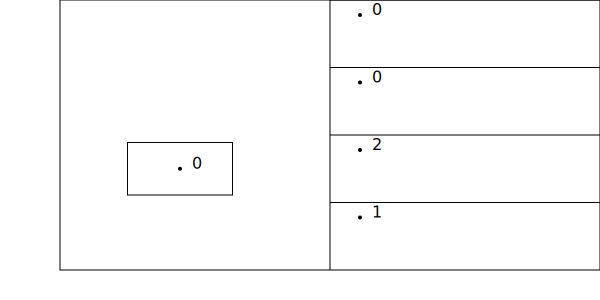

step 3
{'floor2': 1, 'floor3': 0, 'floor1': 1, 'floor4': 0}


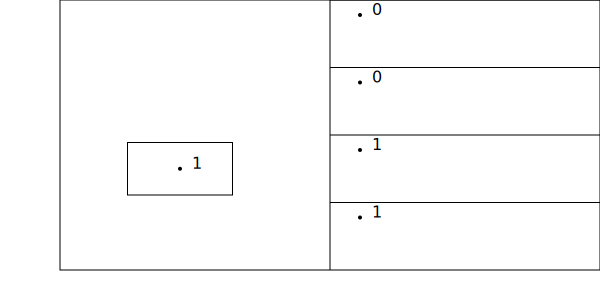

step 4
{'floor2': 0, 'floor3': 0, 'floor1': 1, 'floor4': 0}


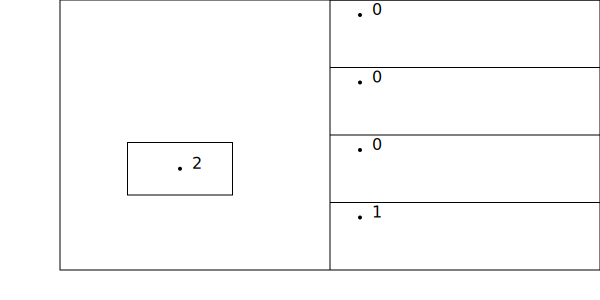

step 5
{'floor2': 0, 'floor3': 0, 'floor1': 1, 'floor4': 0}


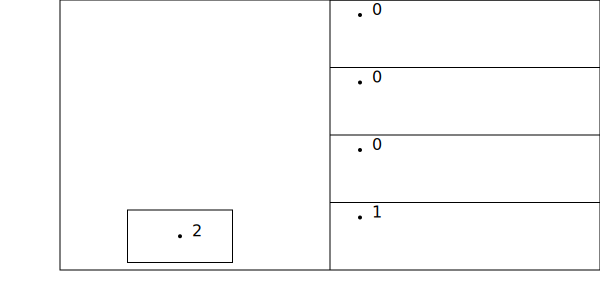

step 6
{'floor2': 0, 'floor3': 0, 'floor1': 0, 'floor4': 0}


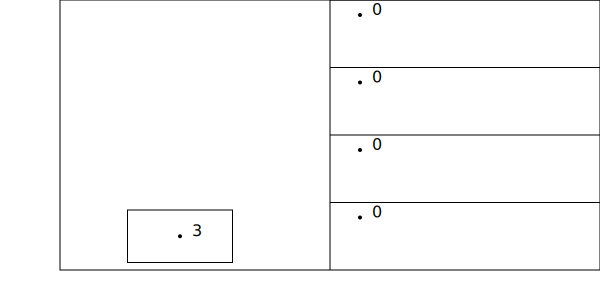

step 7
{'floor2': 0, 'floor3': 0, 'floor1': 1, 'floor4': 0}


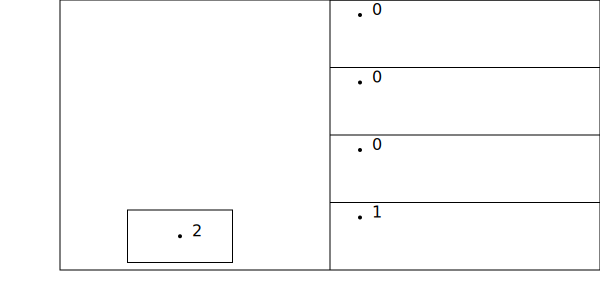

step 8
{'floor2': 0, 'floor3': 0, 'floor1': 2, 'floor4': 0}


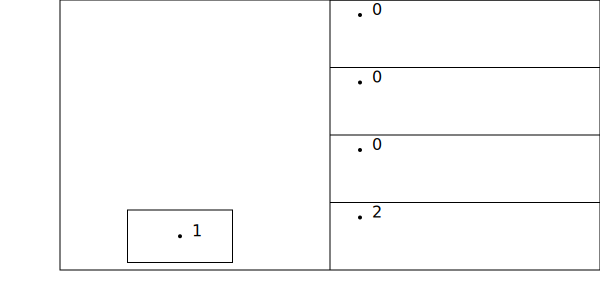

step 9
{'floor2': 0, 'floor3': 0, 'floor1': 2, 'floor4': 0}


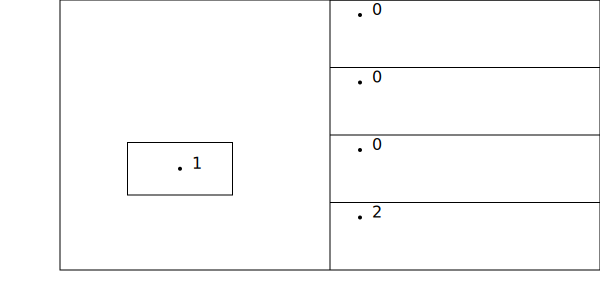

step 10
{'floor2': 0, 'floor3': 0, 'floor1': 2, 'floor4': 0}


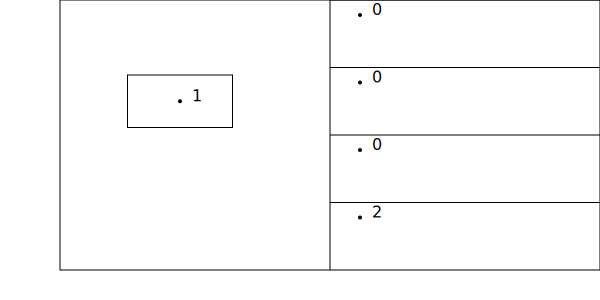

step 11
{'floor2': 0, 'floor3': 1, 'floor1': 2, 'floor4': 0}


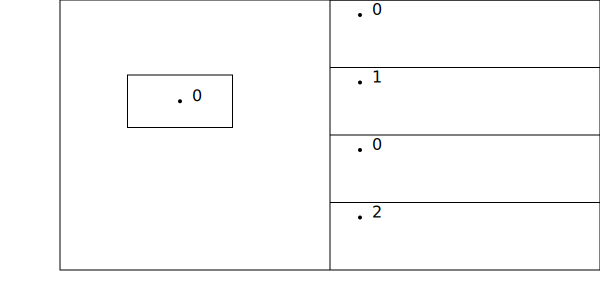

In [8]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if True: #len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

## 2. Requirement Analysis of the CBR engine Project

In this section we analayse both, the requirements from a user perspective and from a technical point of view. 

### 2.1. Requirements: Users's perspective

Our system, general as it is, can be used in any sort of application in which is interesting the use of a planning system. In any domain in which a user has a problem which can be solved with planning techniques, our project is useful, so that, there are no requirements from the perspective of potential users. They will depend on the specific application of use.

Note that the work developed in this project could be used by specialized people with technical knowledge and this include both, researchers and product designers at private companies. 

Among the possible domains in which our system could be used we find: robotics, industrial organization, assembly lines or applications related to the use of satellites.

### 2.2. Requirements: Technical view

As it is explained just above, our system is too general to present requirements as specific as: maximum time response of the system or maximum memory size of the system. All these requirements will show up once the our potential users start using our system in a specific application domain. 

When designing our system we tried to address the following specific requirements:

1. The system should be faster than a conventional planner and expand less nodes when searching the solution.

2. The computed heuristic should be as precise as possible. 

3. The CBR system was thought to start learning with simple problems of the specific domain and continue doing so with more difficult and specific problems.

## 3. Functional Architecture of the CBR engine Project

In this project we have designed a system of general purpose, so that the functional architecture is quite simple to be used. Just four different entities take part in our Functional Architecture: 

- **Planner:** It is our system itself, a CBR trained for planning purposes.
- **Domain:** The domain has to be coded (just once) by the user. In order to do so, it is necessary to follow the same syntaxis we have used for our three domains, which is quite intuitive and tries to be as close as possible to PDDL. This is one of the inputs of our CBR system.
- **Problem:** Again, the problem has to be written by the user and it will be another input of our Planner.
- **Plan:** This is the output of our system, the final plan with the actions to be performed in order to solve the input problem. 

Below, we can see an image of how this four elements interact.

<img src='report_figures/functional_architecture.png'>


## 4. Proposed CBR engine Project solution design:

In this section we analyse in depth the design of our CBR engine: the Case Structure and Case Library Structure and the methods used for every CBR cycle step.

### 4.1. Case Structure and Case Library Structure designed

As said in the introduction of this document, our cases are vectors of heuristics. Specificially, we are using eight different heuristics which are computed using an implementation in C of Fast Downward. Fast Downward is a classical planning system based on heuristic search. It can deal with general deterministic planning problems encoded in the propositional fragment of PDDL2.2, including advanced features like ADL conditions and effects and derived predicates (axioms). 

**put reference for FD...M. Helmert (2006) "The Fast Downward Planning System", Volume 26, pages 191-246**

The implementation of Fast Downward includes several heuristics, each of them has four different characteristics we have used to choose them:

- Admissible: h(s) <= h*(s) for all states s

- Consistent: h(s) <= c(s, s') + h(s') for all states s connected to states s' by an action with cost c(s, s')

- Safe: h(s) = infinity is only true for states with h*(s) = infinity

- Preferred operators: this heuristic identifies preferred operators

From all heuristics provided by the cited implementation, we have chosen the following eight to conform our cases vectors:

- Additive (add)

- Additive CEGAR (cegar) 

- Causal Graph (cg)

- Canonical PDB (cpdbs)

- FF (ff)

- Global Count (globalcount)

- Max Heuristic (hmax)

- Landmark Cut (lmcut)

The computation of all these heuristics increases the time of execution of our code, since it is necesary to call C code from Python. That is one of the reasons why we decided to implement some of the heuristics in Python. However, we just have time to do so with the ones we identify as fast and good enough: Additive and Relaxed Planning Graph.

Regarding the Case Library Structure, we have used *k-d tree*, which is useful for recover the sublinear time in the most similar cases, in our case, the vector of heuristics. The value of 'k' corresponds to the number of heuristics we use, eitght.

### 4.2. Methods of every CBR cycle step

Case-based reasoning has been formalized for purposes of computer reasoning as a four-step process:

- **Retrieve:** Given a target problem, retrieve from memory cases relevant to solving it. In our case, we select the retrieved solution using the K-Nearest Neighbors (KNN) algorithm. The value of K has been chosen empirically after some experiments. This election should be improved in future versions of our system.

- **Reuse (Adaptation):** Map the solution from the previous case to the target problem. This may involve adapting the solution as needed to fit the new situation. In our case we do not adapt the retrieved solution, of course, a more intelligent behaviour should be implemented in future work.

- **Revise:** Having mapped the previous solution to the target situation, test the new solution in the real world (or a simulation) and, if necessary, revise. We compare our solution to the solution given by the A* algorithm in the case of using just one heuristic, the additive. We have chosen that heuristic because it works pretty well and is faster. Those are some of the reasons why we directly have implemented it in Python.

- **Retain:** After the solution has been successfully adapted to the target problem, store the resulting experience as a new case in memory. We have decided to learn every plan we generate, of course, we could improve this with a smarter strategy.

## 5. Testing

## 6. Evaluation